# Домашнее задание 1 (29 + 25 + 27 + 30 = 111 pts)

## Задача 4. Сжатие полносвязных слоёв в нейросети (30 pts)

В этой задаче вам предлагается исследовать, как изменится точность предсказания нейросети, которая классифицирует изображения, если вместо полносвязных слоёв использовать их сжатое представление, полученное с помощью SVD. Результатом решения этой задачи должен быть график зависимости точности классификации на тестовой выборке от количества параметров нейронной сети.

#### Сначала скачаем данные CIFAR10

In [400]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

batch_size = 100

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_loader = torch.utils.data.DataLoader(datasets.CIFAR10('./', train=True, download=True, transform=transform), 
                                        batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(datasets.CIFAR10('./', train=False, transform=transform), 
                                          batch_size=batch_size, shuffle=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


#### Посмотрим, как выглядят изображения

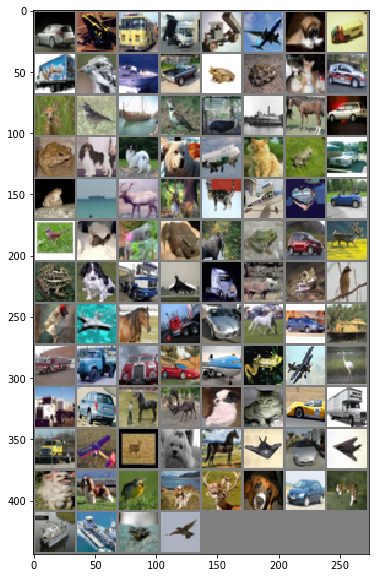

  car  frog truck truck truck plane   dog truck


In [401]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(20, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(8)))


### Архитектура нейронной сети

Для простоты и демонстрации принципа сжатия слоёв нейронных сетей рассмотрим архитектуру, состоящую только из полносвязных слоёв (то есть линейных преобразований) и стандартных ReLU-нелинейностей. Опять же для наглядности выбрали размерность 1000 для полносвязных слоёв. 

In [402]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, 1000)
        self.fc2 = nn.Linear(1000, 1000)
        self.fc3 = nn.Linear(1000, 1000)
        self.fc4 = nn.Linear(1000, 1000)
        self.fc5 = nn.Linear(1000, 1000)
        self.fc6 = nn.Linear(1000, 10)
        self.ReLU = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x.view(-1, 3 * 32*32))
        x = self.ReLU(x)
        x = self.fc2(x)
        x = self.ReLU(x)
        x = self.fc3(x)
        x = self.ReLU(x)
        x = self.fc4(x)
        x = self.ReLU(x)
        x = self.fc5(x)
        x = self.ReLU(x)
        x = self.fc6(x)
        return F.log_softmax(x, dim=1)

#### Функции для обучения и тестирования результата после каждого прохождения всех данных 

In [403]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


In [404]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
#             data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset)

### Зададим параметры обучения и вывода промежуточных результатов

In [405]:
log_interval = 50
epochs = 7

### Запускаем обучение с помощью метода оптимизации [Adam](https://arxiv.org/pdf/1412.6980.pdf%20%22%20entire%20document) 
Если у вас не очень мощный ноутбук, то придётся подождать некоторое время. 

In [406]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(1, epochs + 1):
    train(model,  train_loader, optimizer, epoch)
    test(model, test_loader)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.302219
Train Epoch: 1 [5000/50000 (10%)]	Loss: 1.893983
Train Epoch: 1 [10000/50000 (20%)]	Loss: 1.853646
Train Epoch: 1 [15000/50000 (30%)]	Loss: 1.833566
Train Epoch: 1 [20000/50000 (40%)]	Loss: 1.732731
Train Epoch: 1 [25000/50000 (50%)]	Loss: 1.713555
Train Epoch: 1 [30000/50000 (60%)]	Loss: 1.540359
Train Epoch: 1 [35000/50000 (70%)]	Loss: 1.709333
Train Epoch: 1 [40000/50000 (80%)]	Loss: 1.580906
Train Epoch: 1 [45000/50000 (90%)]	Loss: 1.611016

Test set: Average loss: 1.5875, Accuracy: 4448/10000 (44%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.552208
Train Epoch: 2 [5000/50000 (10%)]	Loss: 1.635604
Train Epoch: 2 [10000/50000 (20%)]	Loss: 1.794920
Train Epoch: 2 [15000/50000 (30%)]	Loss: 1.401336
Train Epoch: 2 [20000/50000 (40%)]	Loss: 1.414621
Train Epoch: 2 [25000/50000 (50%)]	Loss: 1.503566
Train Epoch: 2 [30000/50000 (60%)]	Loss: 1.488359
Train Epoch: 2 [35000/50000 (70%)]	Loss: 1.448504
Train Epoch: 2 [40000/50000 (80%)]	Loss: 1.590056
T

- (3 pts) Вычислите SVD для матрицы $1000 \times 1000$, которая соответствует любому слою подходящего размера обученной нейросети. Покажите на графике убывание сингулярных чисел. Какой вывод можно сделать?
- (12 pts) Создайте модель (аналогично классу ```Net```), которая на вход будет принимать экземпляр класса ```Net``` и ранг $r > 0$. Эта модель должна сжимать все полносвязные слои с помощью SVD разложения, из которого берутся только первые $r$ компонент. Также функция ```forward``` должна быть эффективно реализована с использованием сжатого представления полносвязных слоёв, а в остальном полностью повторять эту же функцию для несжатой обученной сети.
- (5 pts) Постройте зависимость точности предсказания на тестовой выборе от количества параметров, которое необходимо для этого. Это количество, очевидно, некоторым образом зависит от заданного ранга сжатия $r$. Также постройте зависимость времени вычисления от ранга сжатия. Объясните полученные результаты. Для вычисления времени используйте [%timeit](https://docs.python.org/3.6/library/timeit.html) c необходимыми параметрами (примеры смотрите в лекции) 

- Вычислим SVD для второго линейного слоя (первого слоя размерности $1000\times 1000$) и изучим разложение

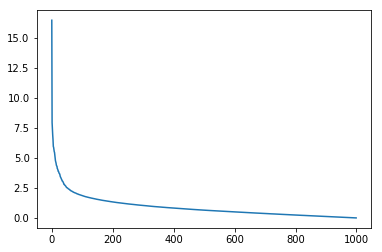

In [407]:
W = model.fc2.weight.detach().numpy()
_, s, __ = np.linalg.svd(W)
%matplotlib inline
plt.plot(s)

Как мы можем заметить, матрица весов имеет достаточное большое (около 80%) количество малых (меньше 1/6 от максимального значения) значений, таким образом, ее можно существенно сжать без потери "полезной информации"

- Создадим требуемый класс. Основная идея эффективной реализации, отбросить $n-r$ последних сингулярных чисел и соответсвующих им векторов и получить разложение:

$$A \approx U_{rs} V,$$
где $U_{rs} = U_rS_r\in\mathbb{R}^{n_{in}\times r}, V_r \in \mathbb{R}^{r\times n_{out}}$. И сначала умножить входной вектор на $V_r$, а после этого на $U_r$. В результате, потребуется $O((n_{in} + n_{out})r)$  операций вместо $O(n_{in}n_{out})$. Добавление сдвига происходит так же как и раньше, и количество операций на это не меняется.

С учетом того, что последний слой и так достаточно мал ($1000\times 10$), мы не будем его сжимать

In [408]:
class effect_linear(nn.Module):
    def __init__(self, W, b, r):
        super(effect_linear, self).__init__()
        self.fc_1 = nn.Linear(W.shape[1], r, bias = False)
        self.fc_2 = nn.Linear(r, W.shape[0])
        U, V = self.compress(W, r)
        with torch.no_grad():
            self.fc_1.weight = nn.Parameter(torch.tensor(V))
            self.fc_2.weight = nn.Parameter(torch.tensor(U))
        self.fc_2.bias = b
    
    def compress(self, W, r):
        U, s, V = np.linalg.svd(W)
        U = U[:, :r] @ np.diag(s[:r])
        V = V[:r]    
        return U, V
    
    def forward(self, x):
        return self.fc_2(self.fc_1(x))


class Net_compress(nn.Module):
    def __init__(self, net, r = None):
        super(Net_compress, self).__init__()
        self.fc1 = effect_linear(net.fc1.weight.detach().numpy(), net.fc1.bias, r)      
        self.fc2 = effect_linear(net.fc2.weight.detach().numpy(), net.fc2.bias, r)      
        self.fc3 = effect_linear(net.fc3.weight.detach().numpy(), net.fc3.bias, r)      
        self.fc4 = effect_linear(net.fc4.weight.detach().numpy(), net.fc4.bias, r)      
        self.fc5 = effect_linear(net.fc5.weight.detach().numpy(), net.fc5.bias, r)
        self.fc6 = net.fc6     
        self.ReLU = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x.view(-1, 3 * 32*32))
        x = self.ReLU(x)
        x = self.fc2(x)
        x = self.ReLU(x)
        x = self.fc3(x)
        x = self.ReLU(x)
        x = self.fc4(x)
        x = self.ReLU(x)
        x = self.fc5(x)
        x = self.ReLU(x)
        x = self.fc6(x)
        return F.log_softmax(x, dim=1)

- Построим график качества от количества параметров модели. Количество параметров в каждом слое легко подсчитывается, как количество параметров в матрице весов плюс количество параметров сдвига (см. формулу для переменной num_params)

In [409]:
r_list = [5, 10, 20, 40, 80, 160, 400, 800, 1000]
num_params_list = []
acc_list = []
for r in r_list:
    new_model = Net_compress(model, r)
    num_params = (2 * 1000 * r * 4 + (1000 + 3 * 32*32) * r + 3 * 32*32 + 4* 1000 + 1000 * 10)
    num_params_list.append(num_params)
    acc = test(new_model, test_loader)
    acc_list.append(acc)


Test set: Average loss: 2.4386, Accuracy: 2137/10000 (21%)


Test set: Average loss: 2.3076, Accuracy: 3269/10000 (33%)


Test set: Average loss: 1.9954, Accuracy: 4253/10000 (43%)


Test set: Average loss: 1.5283, Accuracy: 5167/10000 (52%)


Test set: Average loss: 1.3901, Accuracy: 5404/10000 (54%)


Test set: Average loss: 1.3465, Accuracy: 5434/10000 (54%)


Test set: Average loss: 1.3365, Accuracy: 5425/10000 (54%)


Test set: Average loss: 1.3386, Accuracy: 5445/10000 (54%)


Test set: Average loss: 1.3389, Accuracy: 5448/10000 (54%)



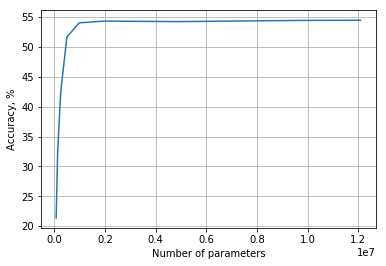

In [410]:
%matplotlib inline
plt.plot(num_params_list, acc_list)
plt.xlabel("Number of parameters")
plt.ylabel("Accuracy, %")
plt.grid()

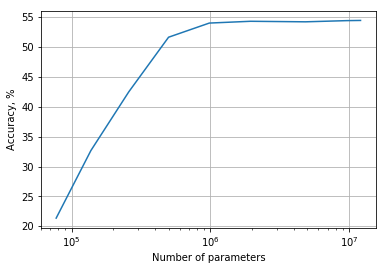

In [411]:
%matplotlib inline
plt.plot(num_params_list, acc_list)
plt.xlabel("Number of parameters")
plt.ylabel("Accuracy, %")
plt.xscale("log")
plt.grid()

Для наглядности снизу график в логарифмическом масштабе. Как можем заметить, мы можем убрать значительное число параметров без потери качества.

Также измерим время работы каждой модели.

In [412]:
time_list = []
for r in r_list:
    new_model = Net_compress(model, r)
    t = %timeit -o -q -r 1 test(new_model, test_loader)
    time_list.append(t)


Test set: Average loss: 2.4386, Accuracy: 2137/10000 (21%)


Test set: Average loss: 2.4386, Accuracy: 2137/10000 (21%)


Test set: Average loss: 2.3076, Accuracy: 3269/10000 (33%)


Test set: Average loss: 2.3076, Accuracy: 3269/10000 (33%)


Test set: Average loss: 1.9954, Accuracy: 4253/10000 (43%)


Test set: Average loss: 1.9954, Accuracy: 4253/10000 (43%)


Test set: Average loss: 1.5283, Accuracy: 5167/10000 (52%)


Test set: Average loss: 1.5283, Accuracy: 5167/10000 (52%)


Test set: Average loss: 1.3901, Accuracy: 5404/10000 (54%)


Test set: Average loss: 1.3901, Accuracy: 5404/10000 (54%)


Test set: Average loss: 1.3465, Accuracy: 5434/10000 (54%)


Test set: Average loss: 1.3465, Accuracy: 5434/10000 (54%)


Test set: Average loss: 1.3365, Accuracy: 5425/10000 (54%)


Test set: Average loss: 1.3365, Accuracy: 5425/10000 (54%)


Test set: Average loss: 1.3386, Accuracy: 5445/10000 (54%)


Test set: Average loss: 1.3386, Accuracy: 5445/10000 (54%)


Test set: Average loss:

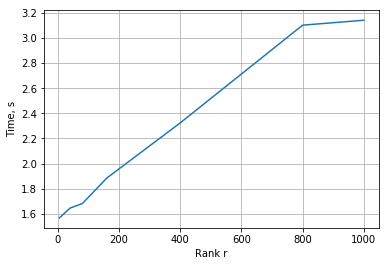

In [413]:
%matplotlib inline
time_list = [t.best for t in time_list]
plt.plot(r_list, time_list)
plt.xlabel("Rank r")
plt.ylabel("Time, s")
plt.grid()

Как можно легко видеть, мы можем сжать до ранга 100 почти без потери качества (см.пред. график), ускорив нейросеть почти в два раза!

### Fine-tuning

- (10 pts) Поскольку в вашей модели, которая использует сжатое представление линейных слоёв, параметрами являются матрицы, полученные из SVD соответствующих линейных слоёв, то их также можно оптимизировать. Эта процедура называется fine-tuning. Предлагается провести обучение этих матриц в течение нескольких эпох (от 1 до 5 будет достаточно) и сравнить насколько выросло качество по сравнению с первоначальными значениями. Покажите значения точности на тестовой выборки и объясните полученные результаты.

Дообучим несколько моделей с $r\leq 100$ и посмотрим на результат.

In [416]:
r_list = [5, 40, 80, 100]
num_params_list = []
acc_list_improved = []
acc_list = []
epochs = 2
for r in r_list:
    new_model = Net_compress(model, r)
    num_params = (2 * 1000 * r * 4 + (1000 + 3 * 32*32) * r + 3 * 32*32 + 4* 1000 + 1000 * 10)
    num_params_list.append(num_params)
    acc = test(new_model, test_loader)
    acc_list.append(acc)
    for epoch in range(1, epochs + 1):
        train(new_model,  train_loader, optimizer, epoch)
    
    acc = test(new_model, test_loader)
    acc_list_improved.append(acc)


Test set: Average loss: 2.0413, Accuracy: 2687/10000 (27%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.055242
Train Epoch: 1 [5000/50000 (10%)]	Loss: 2.064237
Train Epoch: 1 [10000/50000 (20%)]	Loss: 2.069461
Train Epoch: 1 [15000/50000 (30%)]	Loss: 1.969823
Train Epoch: 1 [20000/50000 (40%)]	Loss: 1.913959
Train Epoch: 1 [25000/50000 (50%)]	Loss: 2.008145
Train Epoch: 1 [30000/50000 (60%)]	Loss: 1.992680
Train Epoch: 1 [35000/50000 (70%)]	Loss: 2.013119
Train Epoch: 1 [40000/50000 (80%)]	Loss: 2.133252
Train Epoch: 1 [45000/50000 (90%)]	Loss: 1.964510
Train Epoch: 2 [0/50000 (0%)]	Loss: 2.106076
Train Epoch: 2 [5000/50000 (10%)]	Loss: 1.987650
Train Epoch: 2 [10000/50000 (20%)]	Loss: 1.966956
Train Epoch: 2 [15000/50000 (30%)]	Loss: 2.017283
Train Epoch: 2 [20000/50000 (40%)]	Loss: 1.903557
Train Epoch: 2 [25000/50000 (50%)]	Loss: 1.864451
Train Epoch: 2 [30000/50000 (60%)]	Loss: 1.867656
Train Epoch: 2 [35000/50000 (70%)]	Loss: 1.999866
Train Epoch: 2 [40000/50000 (80%)]	Loss: 2.026941
T

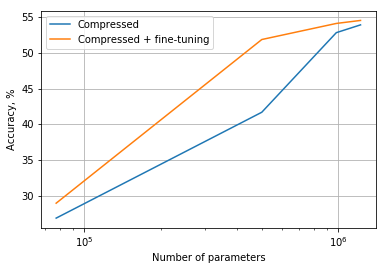

In [417]:
%matplotlib inline
plt.plot(r_list, acc_list)
plt.plot(r_list, acc_list_improved)
plt.xlabel("Number of parameters")
plt.ylabel("Accuracy, %")
plt.xscale("log")
plt.legend(["Compressed", "Compressed + fine-tuning"])
plt.grid()

Как можно видеть, после fine-tuning модель можно сжать еще на $\sim 20\%$ (от уже сжатой до 100 почти без потери качества).